# Read & visualise grace files

In [1]:
from grace.base import GraphAttrs
from grace.io import read_graph
from grace.napari.utils import EdgeColor
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import mrcfile


In [2]:
path = "/Users/kulicna/Desktop/dataset/data_fake/infer/corner/MRC_File_005"
anno = path + ".grace"
file = path + ".mrc"


In [3]:
dataset = read_graph(Path(anno))
dataset.metadata

{'image_filename': 'MRC_File_005'}

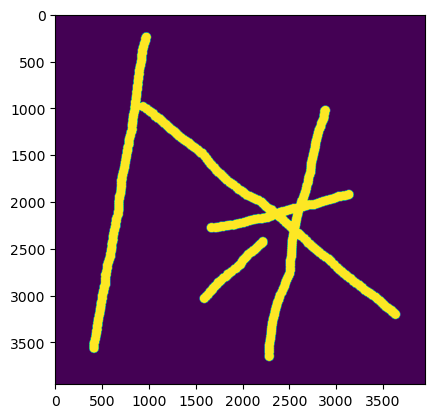

In [4]:
plt.imshow(dataset.annotation)

In [5]:
graph = dataset.graph
graph

In [6]:
graph.nodes(data=True)[0]

{<GraphAttrs.NODE_X: 'x'>: 2389.09033203125,
 <GraphAttrs.NODE_Y: 'y'>: 1206.11669921875,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>,
 <GraphAttrs.NODE_FEATURES: 'features'>: None}

### Read the file:

In [7]:
with mrcfile.open(file, "r") as mrc:
    image_data = mrc.data

Text(0.5, 1.0, 'MRC_File_005')

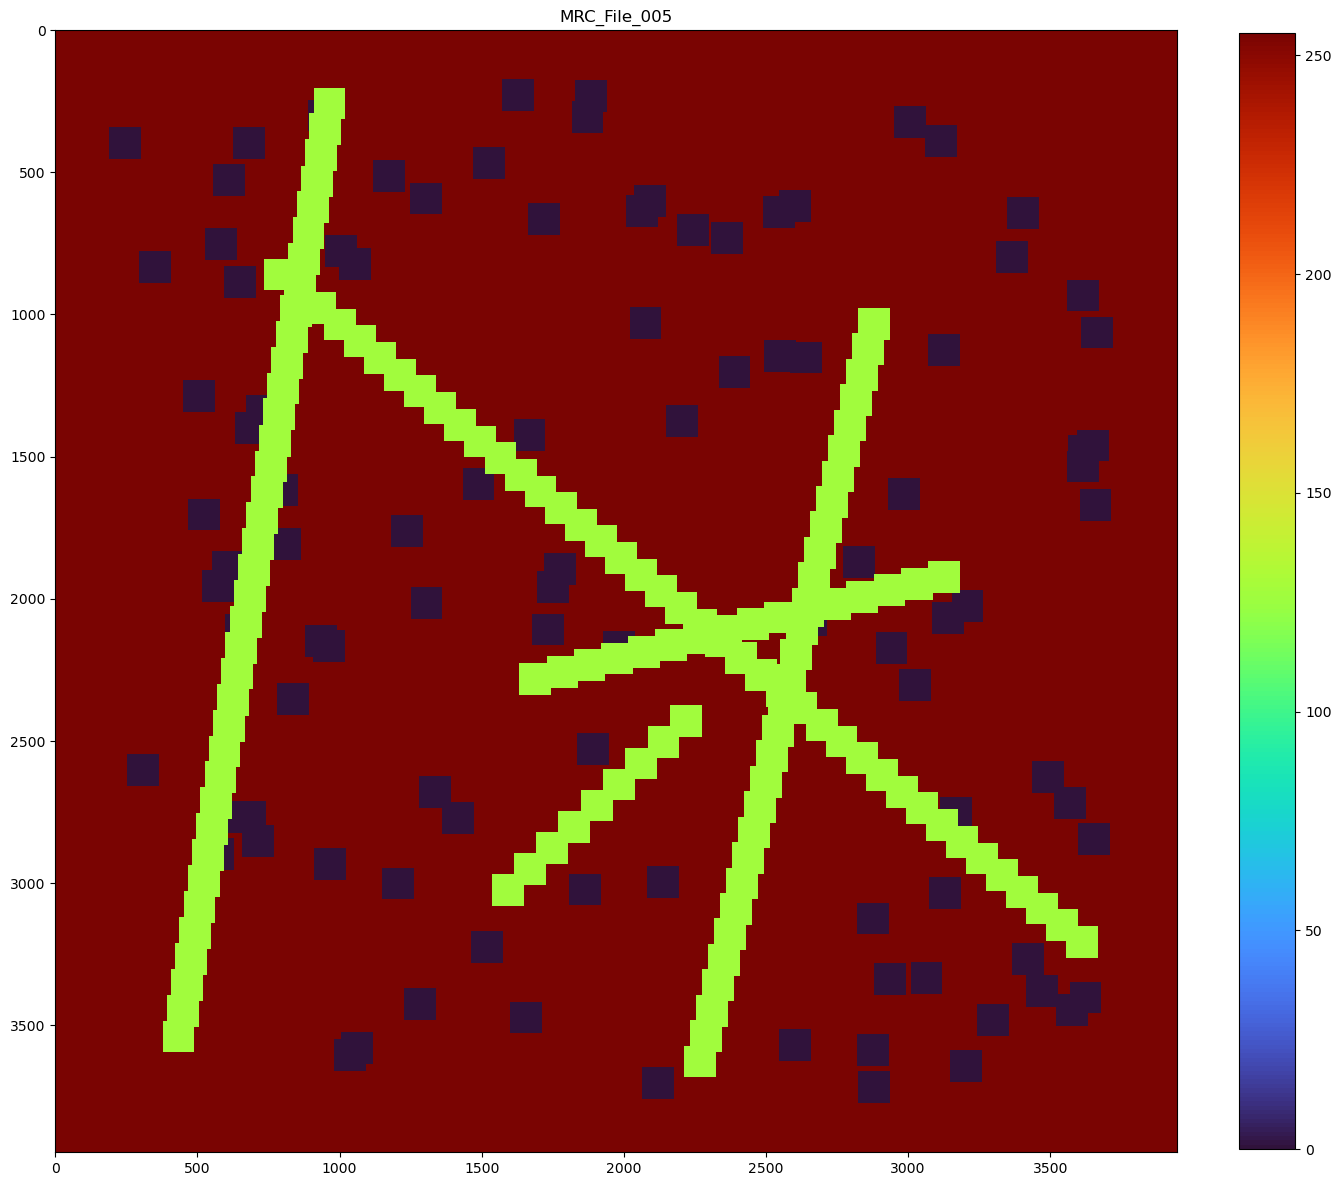

In [8]:
plt.figure(figsize=(16, 16))
plt.imshow(image_data, cmap=plt.cm.turbo, interpolation="none")
plt.colorbar(fraction=0.045)
plt.title(dataset.metadata["image_filename"])


### Read the annotation:

Text(0.5, 1.0, 'MRC_File_005')

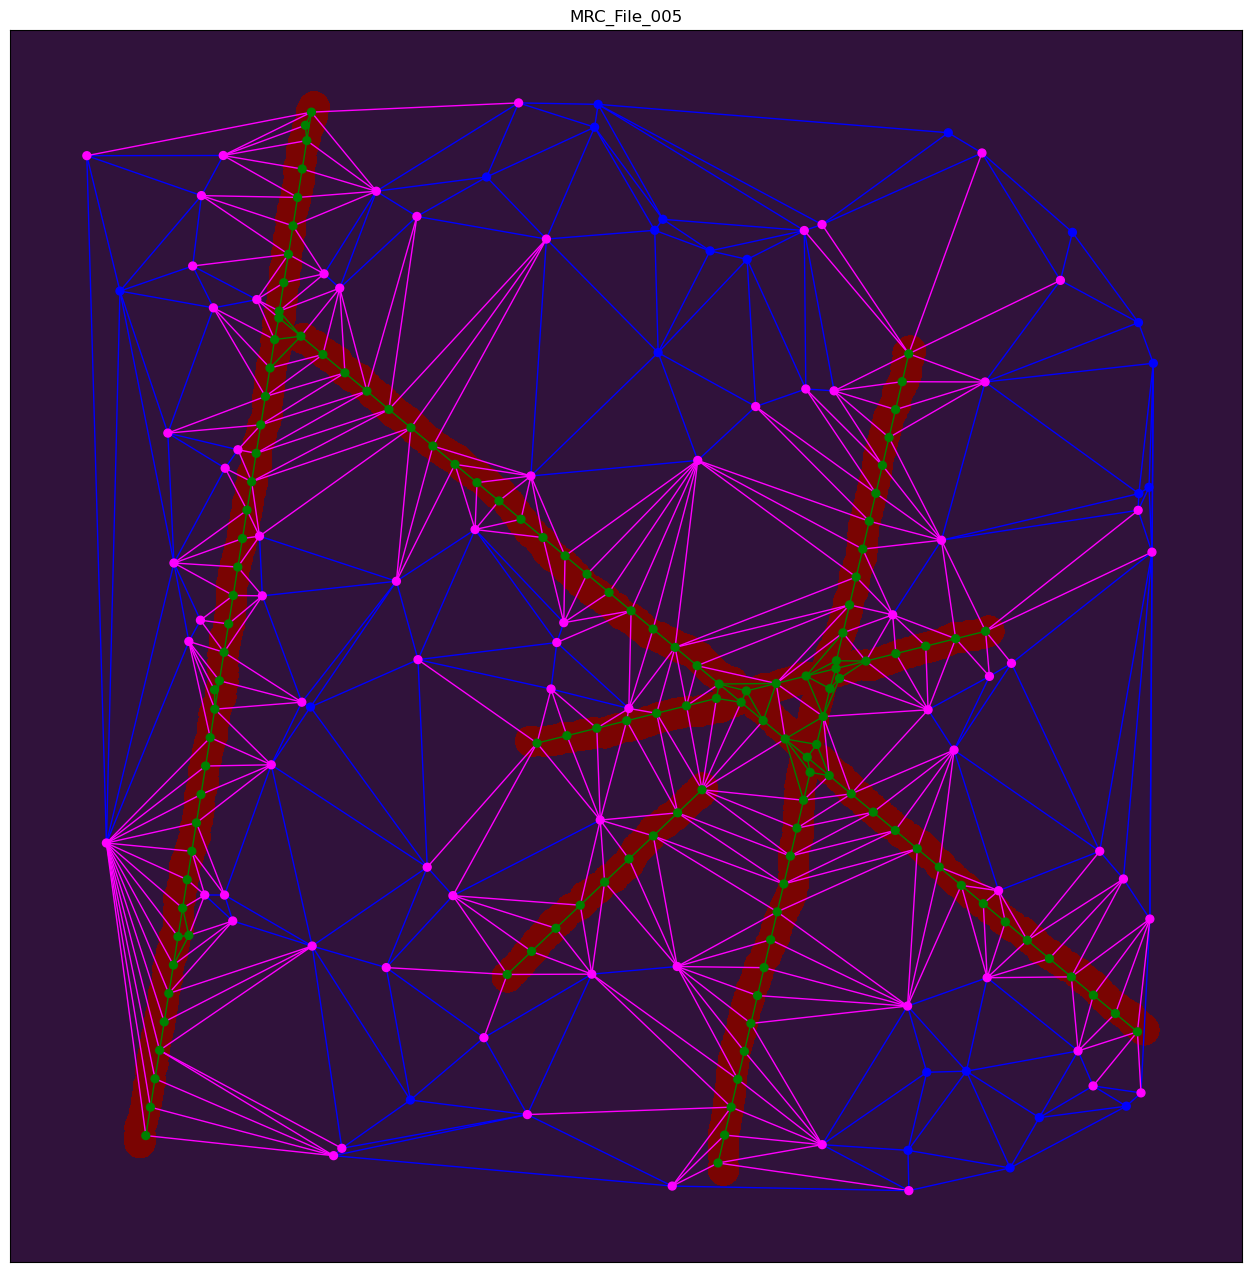

In [9]:

fig, ax = plt.subplots(figsize=(16, 16))

# node positions
pos = {
    idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) 
    for idx, node in graph.nodes(data=True)
}
# edge annotations
edge_gt = [graph[u][v][GraphAttrs.EDGE_GROUND_TRUTH] for u, v in graph.edges]
edge_colors = [EdgeColor[gt.name].value for gt in edge_gt]

node_colors = [
    EdgeColor[node_attrs[GraphAttrs.NODE_GROUND_TRUTH].name].value 
    for _, node_attrs in graph.nodes(data=True)
]

ax.imshow(dataset.annotation, cmap=plt.cm.turbo, interpolation="none")

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(
    dataset.graph, 
    ax=ax, 
    pos=pos, 
    with_labels=False, 
    # node_color="w", 
    node_size=32,
    edge_color=edge_colors,
    node_color=node_colors,
)

ax.set_title(dataset.metadata["image_filename"])

##### Done!